<font face="Calibri" size="2"> <i>Open SAR Toolkit - Tutorial 3, version 1.1, November 2019. Andreas Vollrath, ESA/ESRIN phi-lab</i>
</font>

![title](auxiliary/header_image.PNG)

--------

# OST Tutorial III
## Create latest Sentinel-1 GRD product for a given point

--------

**Short description**

This notebook show the interaction between the *Sentinel1* class for data inventory and download, and the *Sentinel1_Scene* class, together, for the generation of the latest Sentinel-1 product over a given point coordinate. 

--------

**Requirements**

- a PC/Mac with at least 16GB of RAM
- about 4GB of free disk space
- a Copernicus Open Data Hub user account, valid for at least 7 days (https://scihub.copernicus.eu)
--------

**NOTE:** all cells that have an * after its number can be executed without changing any code. 

### 1* - Import python libraries necessary for processing

In [1]:
# this is for the path handling and especially useful if you are on Windows
import os
from os.path import join
from pprint import pprint

# we will need this for our time of period definition
from datetime import datetime, timedelta
import pandas as pd

# this is the s1Project class, that basically handles all the workflow from beginning to the end
from ost import Sentinel1, Sentinel1Scene as S1Scene

### 2 - Data selection parameters

**NOTE:** At this point all you want to change is the lat and lon values in line 6.


In order to define the data you want to process you need to define 2 basic settings. 

**1 Area of Interest:** 

In our case we only look for a *specific spot on earth*, that is defined by the *Latitude* and *Longitude*. 

**2 Time of Interest:**

The time of interest is usually defined by a *start* and *end* date. The format should be conform with 'YYYY-MM-DD'. If none of the two parameters are defined, both parameters will use default values, which is the *2014-10-01* for *start*, and *today* for the end of the TOI.

In our example here, the datetime class is used to set the start date to 30 days before today to assure we get any scene within our time of interest.

**3 Project directory**

OST bases usually on a certain directory hierarchy that includes download, inventory and processing. Even though we just want to process a single scene, it is more handy to split these parts for this given example. 



In [2]:
#----------------------------
# Area of interest
#----------------------------

# Here we can either point to a shapefile or as well use 
lat, lon = 41.8919, 12.5113
aoi = 'POINT ({} {})'.format(lon, lat)

#----------------------------
# Time of interest
#----------------------------
# we set only the start date to today - 30 days
start = (datetime.today() - timedelta(days=30)).strftime("%Y-%m-%d")

#----------------------------
# Processing directory
#----------------------------
# get home folder
home = os.getenv('HOME')
# create a processing directory
project_dir = join(home, 'Tutorial_3')

#------------------------------
# Print out AOI and start date
#------------------------------
print('AOI: ' + aoi, )
print('TOI start: ' + start)

AOI: POINT (12.5113 41.8919)
TOI start: 2020-01-20


### 3* - Initialize the Sentinel1 project class

/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


 Your Copernicus Scihub Username: suprd
 Your Copernicus Scihub Password: ·········


We found 15 products.
   id                                         identifier polarisationmode  \
0   1  S1A_IW_GRDH_1SDV_20200219T051951_20200219T0520...            VV VH   
1   2  S1B_IW_GRDH_1SDV_20200214T170502_20200214T1705...            VV VH   
2   3  S1A_IW_GRDH_1SDV_20200214T051204_20200214T0512...            VV VH   
3   4  S1B_IW_GRDH_1SDV_20200213T051926_20200213T0519...            VV VH   
4   5  S1A_IW_GRDH_1SDV_20200208T170545_20200208T1706...            VV VH   

  orbitdirection acquisitiondate relativeorbit orbitnumber product_type  \
0     DESCENDING        20200219            95       31317          GRD   
1      ASCENDING        20200214           117       20268          GRD   
2     DESCENDING        20200214            22       31244          GRD   
3     DESCENDING        20200213            95       20246          GRD   
4      ASCENDING        20200208           117       31164          GRD   

  slicenumber     size  ... lastrelativeorbitnumber lastorbitnum

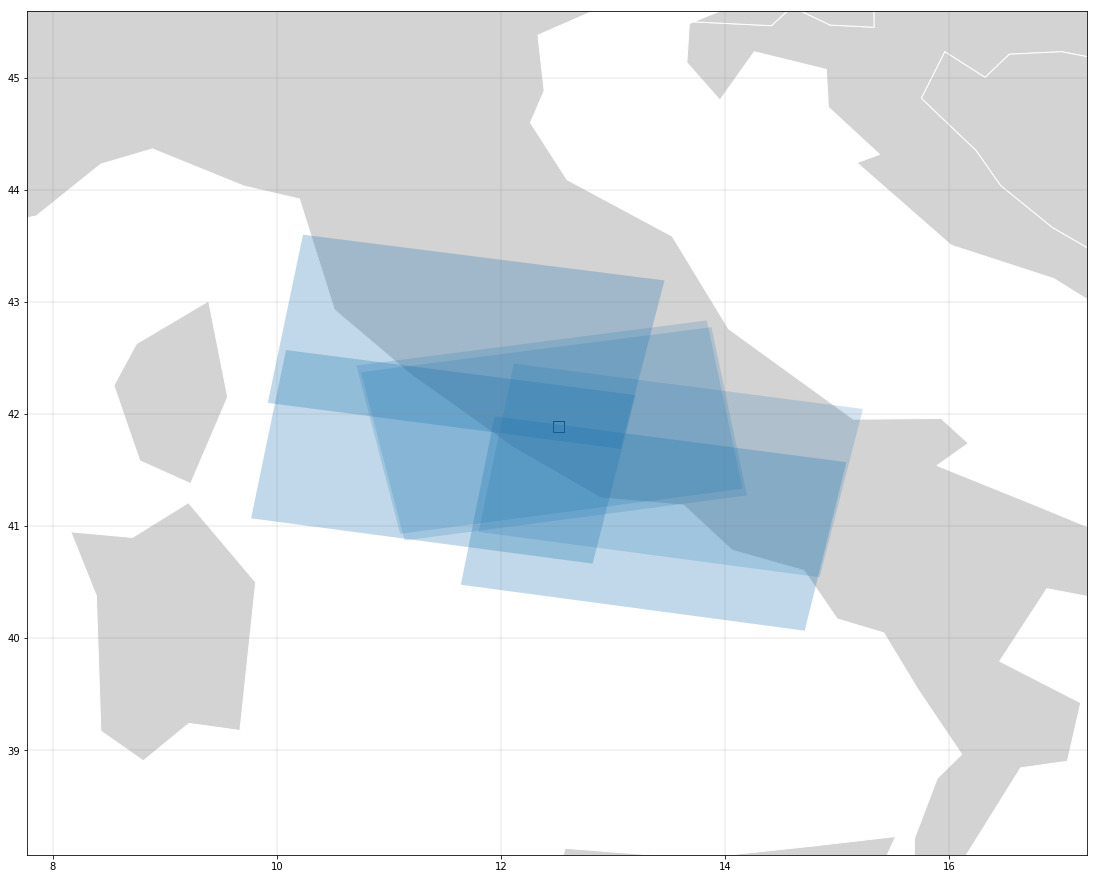

In [3]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)
#---------------------------------------------------

# create s1Project class instance
s1_project = Sentinel1(
    project_dir=project_dir, 
    aoi=aoi, 
    start=start,
    product_type='GRD'
)

# search command
s1_project.search()

print('We found {} products.'.format(len(s1_project.inventory.identifier.unique())))
# combine OST class attribute with pandas head command to print out the first 5 rows of the 
print(s1_project.inventory.head(5))

# we plot the full Inventory on a map
s1_project.plot_inventory(transperancy=.1)

### 4* - Select the latest scene found during the search

Here we use some python-panda syntax to filter out the latest scene. If you do not understand what's going on, don't worry. It should just show how 

 INFO: Latest scene found for 20200121


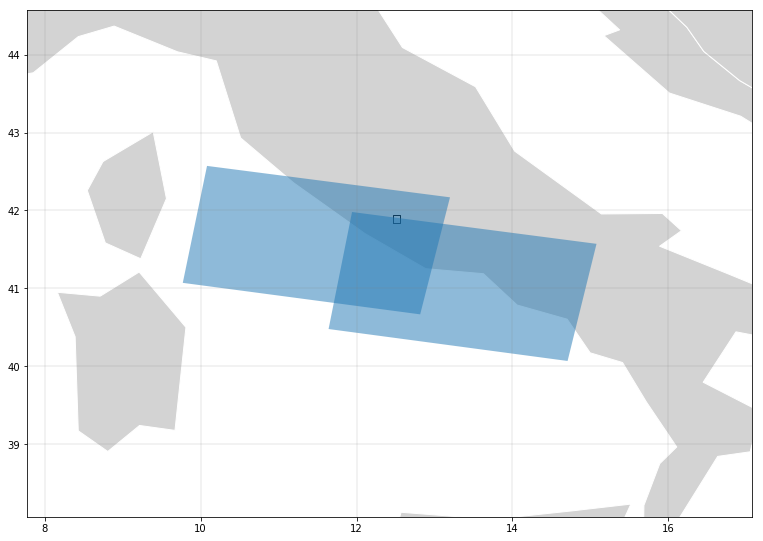

In [4]:
pylab.rcParams['figure.figsize'] = (13, 13)

# we give our inventory a shorter name iDf (for inventory Dataframe)
iDf = s1_project.inventory.copy()

# we select the latest two scenes based on the metadata entry endposition (in case one is not online for downloading)
iDf = iDf[iDf.tail(2) == iDf.tail(2)]
# Drop empty entries and rewrite project inventory
iDf = iDf[iDf['id'].notna()]

s1_project.inventory = iDf


# we print out a little info on the date of the  
print(' INFO: Latest scene found for {}'.format(s1_project.inventory['acquisitiondate'].values[0]))

# we use the plotInventory method in combination with the newly
# created Geodataframe to see our scene footprint
s1_project.plot_inventory(s1_project.inventory, transperancy=.5)

### 7* Download scene

We use the build-in download method from the *Sentinel1* class. You can pass any Geodataframe generated by OST, and filtered by you (e.g. sort out rows that you d not need). In our case we are only interested in the latest scene, so we pass the newly generated *latestDf* Geodataframe object.'

In [5]:
# Setup logging so we can see if the scene is not availible
import logging
from ost.log import set_log_level
set_log_level(logging.DEBUG)

s1_project.download(mirror=2)

DEBUG:ost.project:INFO: One or more of your scenes need to be downloaded.
2020-02-19 16:44:45,251 DEBUG ost.project INFO: One or more of your scenes need to be downloaded.
DEBUG:ost.s1_core.s1_dl:Please provide username for the selected server
2020-02-19 16:44:45,252 DEBUG ost.s1_core.s1_dl Please provide username for the selected server


Username: suprd


DEBUG:ost.s1_core.s1_dl:Please provide password for the selected server
2020-02-19 16:44:46,730 DEBUG ost.s1_core.s1_dl Please provide password for the selected server


Password: ·········


DEBUG:ost.helpers.asf:INFO: Downloading scene to: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/21/S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip
2020-02-19 16:44:59,411 DEBUG ost.helpers.asf INFO: Downloading scene to: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/21/S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip
DEBUG:ost.helpers.asf:INFO: Downloading scene to: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/20/S1B_IW_GRDH_1SDV_20200120T051927_20200120T051952_019896_025A24_2596.zip
2020-02-19 16:44:59,412 DEBUG ost.helpers.asf INFO: Downloading scene to: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/20/S1B_IW_GRDH_1SDV_20200120T051927_20200120T051952_019896_025A24_2596.zip


DEBUG:ost.helpers.asf:INFO: Checking the zip archive of /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/21/S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip for inconsistency
2020-02-19 16:45:58,207 DEBUG ost.helpers.asf INFO: Checking the zip archive of /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/21/S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip for inconsistency


DEBUG:ost.helpers.asf:INFO: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/21/S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip passed the zip test.
2020-02-19 16:46:08,764 DEBUG ost.helpers.asf INFO: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/21/S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip passed the zip test.
DEBUG:ost.helpers.asf:INFO: Checking the zip archive of /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/20/S1B_IW_GRDH_1SDV_20200120T051927_20200120T051952_019896_025A24_2596.zip for inconsistency
2020-02-19 16:47:23,360 DEBUG ost.helpers.asf INFO: Checking the zip archive of /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/20/S1B_IW_GRDH_1SDV_20200120T051927_20200120T051952_019896_025A24_2596.zip for inconsistency


DEBUG:ost.helpers.asf:INFO: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/20/S1B_IW_GRDH_1SDV_20200120T051927_20200120T051952_019896_025A24_2596.zip passed the zip test.
2020-02-19 16:47:33,558 DEBUG ost.helpers.asf INFO: /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/20/S1B_IW_GRDH_1SDV_20200120T051927_20200120T051952_019896_025A24_2596.zip passed the zip test.
DEBUG:ost.helpers.asf:INFO: All products are downloaded.
2020-02-19 16:47:33,599 DEBUG ost.helpers.asf INFO: All products are downloaded.


### 8* - Display some metadata of the latest scene

After use of the *Sentinel1* class for the finding and downloading the latest scene, we hand the scene identifier over to the *Sentinel1Scene* class for further processing. 

In [6]:
# create a S1Scene class instance based on the scene identifier coming from our "latest scene dataframe"
latestScene = S1Scene(s1_project.inventory['identifier'].values[0])

# print summarising infos
latestScene.info()

# print file location
fileLocation = latestScene.get_path(s1_project.download_dir)

print(' File is located at: ')
print(' ' + fileLocation)

 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Ground Range Detected (GRD)
 Acquisition Date:        20200121
 Start Time:              051205
 Stop Time:               051230
 Absolute Orbit:          030894
 Relative Orbit:          22
 -------------------------------------------------
 File is located at: 
 /home/jovyan/Tutorial_3/download/SAR/GRD/2020/01/21/S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip


### 9* - Produce an ARD product

Our *Sentinel1_Scene* class comes with the build-in method *create_ard* to produce a standardised ARD product. We just have to provide: 
- the high-level download directory (that we can get from our *s1Project* class instance)
- a directory where the outputfiles will be written 
- a filename prefix (the output format will be the standard SNAP Dimap format, consisting of the dim-file and the data directory)
- and a directory for storing temporary files

It seems a bit messy to mix up both classes. In later tutorials it will become clear why this distinction actually makes sense for effective bulk processing.

In [11]:
latestScene.set_ard_parameters('OST')
latestScene.ard_parameters['resolution'] = 50
pprint(latestScene.ard_parameters)

import tempfile
with tempfile.TemporaryDirectory() as temp:
    latestScene.create_ard(
        filelist=latestScene.get_path(download_dir=s1_project.download_dir), # we see our download path can be automatically generated by providing the Project's download directory...wohooo
        out_dir=s1_project.processing_dir,   
        out_prefix=latestScene.start_date,   # we take the acquisitiondate as filename for our output
        temp_dir=temp
    )

print(' The path to our newly created ARD product can be obtained the following way:')
latestScene.ard_dimap


DEBUG:ost.s1_to_ard.grd_to_ard:INFO: Importing S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip by applying precise orbit file and removing thermal noise
2020-02-19 17:39:54,678 DEBUG ost.s1_to_ard.grd_to_ard INFO: Importing S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C.zip by applying precise orbit file and removing thermal noise


{'border_noise': True,
 'dem': 'SRTM 1Sec HGT',
 'ls_mask_create': False,
 'product_type': 'GTCgamma',
 'resampling': 'CUBIC_CONVOLUTION',
 'resolution': 50,
 'speckle_filter': False,
 'to_db': False,
 'type': 'OST'}


DEBUG:ost.helpers.utils:INFO: Time elapsed: 0:00:24.079084
2020-02-19 17:40:18,767 DEBUG ost.helpers.utils INFO: Time elapsed: 0:00:24.079084
DEBUG:ost.s1_to_ard.grd_to_ard:INFO: Succesfully imported product
2020-02-19 17:40:18,768 DEBUG ost.s1_to_ard.grd_to_ard INFO: Succesfully imported product
DEBUG:ost.s1_to_ard.grd_to_ard:INFO: Remove border noise for VV band.
2020-02-19 17:40:18,770 DEBUG ost.s1_to_ard.grd_to_ard INFO: Remove border noise for VV band.
DEBUG:ost.helpers.utils:INFO: Time elapsed: 0:00:01.486212
2020-02-19 17:40:20,257 DEBUG ost.helpers.utils INFO: Time elapsed: 0:00:01.486212
DEBUG:ost.s1_to_ard.grd_to_ard:INFO: Remove border noise for VH band.
2020-02-19 17:40:20,258 DEBUG ost.s1_to_ard.grd_to_ard INFO: Remove border noise for VH band.
DEBUG:ost.helpers.utils:INFO: Time elapsed: 0:00:01.479268
2020-02-19 17:40:21,738 DEBUG ost.helpers.utils INFO: Time elapsed: 0:00:01.479268
DEBUG:ost.s1_to_ard.grd_to_ard:INFO: Calibrating the product to a GTC product (Gamma0).
20

 The path to our newly created ARD product can be obtained the following way:


'/home/jovyan/Tutorial_3/processing/20200121_GTCgamma_TC.dim'

### 10* - Create a RGB color composite

Sentinel-1 scenes usually consist of two polarisation bands. In order to create a 3 channel RGB composite a ratio between the Co- (VV or HH) and the Cross-polarised (VH or HV) band is added. The *create_rgb* method takes the *ard_dimap* file and converts it to a 3-channel GeoTiff.

In [13]:
latestScene.create_rgb(outfile = os.path.join(s1_project.processing_dir, '{}.tif'.format(latestScene.start_date)))

print(' The path to our newly created RGB product can be obtained the follwing way:')
latestScene.ard_rgb

DEBUG:ost.s1_core.s1scene:Creating RGB Geotiff for scene: S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C
2020-02-19 17:41:46,069 DEBUG ost.s1_core.s1scene Creating RGB Geotiff for scene: S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C
DEBUG:ost.s1_core.s1scene:RGB Geotiff done for scene: S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C
2020-02-19 17:42:03,162 DEBUG ost.s1_core.s1scene RGB Geotiff done for scene: S1A_IW_GRDH_1SDV_20200121T051205_20200121T051230_030894_038BB7_D66C


 The path to our newly created RGB product can be obtained the follwing way:


'/home/jovyan/Tutorial_3/processing/20200121.tif'

### 11 - Visualise the RGB composite

We can plot the newly created RGB image with the *visualise_rgb* method. A *shrink_factor* is added, which reduces resolution in favour of memory requirements for plotting.

/home/jovyan/git/OpenSarToolkit/ost/helpers/raster.py:302: RuntimeWarning: invalid value encountered in greater
  float_array[float_array > max_value] = max_value
/home/jovyan/git/OpenSarToolkit/ost/helpers/raster.py:303: RuntimeWarning: invalid value encountered in less
  float_array[float_array < min_value] = min_value


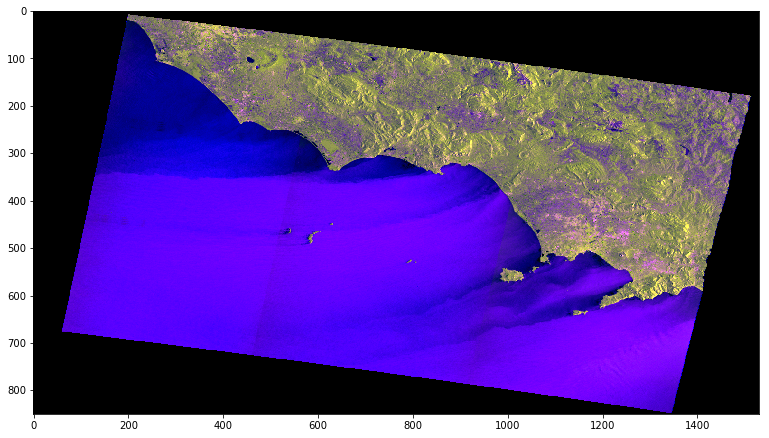

In [14]:
latestScene.visualise_rgb(shrink_factor=5)

### 12 - Create thumbnail image

For some it might be interesting to create a small thumbnail image in Jpeg format. The *createThumbnail* method allows for this. 

12K /home/jovyan/Tutorial_3/processing/20200121.TN.jpg


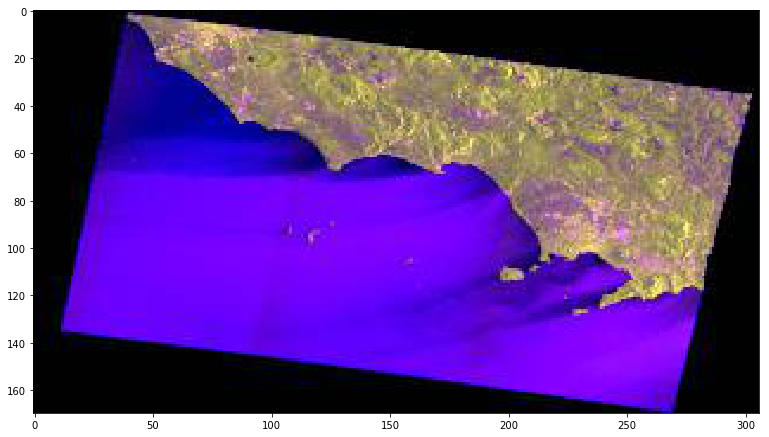

In [17]:
tn_image = os.path.join(s1_project.processing_dir, '{}.TN.jpg'.format(latestScene.start_date))
latestScene.create_rgb_thumbnail(outfile = tn_image)
import imageio
img = imageio.imread(tn_image)
!ls -sh {tn_image}
plt.imshow(img)